---
# Introduction to Graph Neural Networks
---



## **Recommended Book: _Deep Learning for Molecules & Materials_**
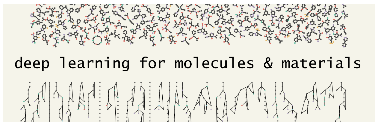

Explore this excellent resource to dive deeper into applying deep learning to molecular and material sciences. 

👉 [Access the book here](https://dmol.pub/index.html)


## Introduction



In This note book we introduce fundamental concepts of deep learning on graphs using Graph Neural Networks, leveraging the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**. PyTorch Geometric, built on [PyTorch](https://pytorch.org/), offers numerous methods and utilities that simplify the implementation of GNNs.


### What is a Graph?

A **graph**  $G$ is a structure composed of two primary elements: **nodes**  $V$ and **edges** $E$.

- **Nodes**: Represent entities or objects.
- **Edges**: Represent relationships or connections between the nodes.

In our context:
- A **node** is defined by a feature vector, which means the set of nodes can be represented as a rank-2 tensor.
- The **edges** can be encoded as an adjacency matrix $ E $, where $ E[i][j] = 1 $ indicates that nodes $ i $ and $ j $ are connected. 

#### Graph Properties in Molecular Systems
1. **Molecular Graphs**:
   - Unlike some graphs in other fields, molecules are **undirected** (chemical bonds have no direction) and often contain **cycles** (rings).
   - As a result, the adjacency matrices for molecular graphs are always symmetric.

2. **Edge Features**:
   - In many cases, edges carry additional features. For example:
     - Covalent bond order.
     - Distance between two atoms.
   - When edges have features, $ E[i][j]$  becomes a vector, and the adjacency matrix is represented as a rank-3 tensor.




## Working With Graph Data

we will use the open-source [PyTorch Geometric](https://www.pyg.org/) library, built on [PyTorch](https://pytorch.org/), to manipulate graph data. 

Other popular libraries for graph deep learning include [DGL](https://www.dgl.ai/), [Spektral](https://graphneural.network/), and [Graph Nets](https://www.deepmind.com/open-source/graph-nets), which provide similar functionality.

In PyTorch Geometric, a graph is represented using the `torch_geometric.data.Data` class. 

Nodes are indexed by their positions in a tensor, and edges are represented by a pair of tensors: `edge_index`, which stores the source and destination node indices, and an optional `edge_attr` tensor for storing edge attributes. `edge_index` is a 2 x E matrix where each column `(u, v)` represents a directed edge from source node `u` to destination node `v`. 

For **undirected** graphs, edges can be made **bidirectional** by duplicating each edge in reverse order in `edge_index`.

A graph can be created in PyTorch Geometric using the `torch_geometric.data.Data` class, where you can specify `x` for node features, `edge_index` for the edge list, and other optional properties like `edge_attr` and `y` (for labels). Once created, nodes and edges can be accessed directly through these properties. The library provides utility functions, such as [`torch_geometric.utils.degree`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.degree) to compute node degrees (number of connections), or other [querying functions](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html) for manipulating and analyzing graph structure.


In [5]:
# Install required packages.
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx


os.environ['TORCH'] = torch.__version__
print(torch.__version__)





c:\Users\alexe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.9.1+cpu


In [6]:
dir(Data)

['__abstractmethods__',
 '__annotations__',
 '__call__',
 '__cat_dim__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__inc__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_edge_to_layout',
 '_edges_to_layout',
 '_find_parent',
 '_get_edge_index',
 '_get_tensor',
 '_get_tensor_size',
 '_multi_get_tensor',
 '_put_edge_index',
 '_put_tensor',
 '_remove_edge_index',
 '_remove_tensor',
 '_to_type',
 '_union',
 'apply',
 'apply_',
 'batch',
 'clone',
 'coalesce',
 'concat',
 'connected_components',
 'contains_isolate

## Helper function for visualization

In [8]:

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()




def plot_graph(G):
    """
    Plots a NetworkX graph.

    Parameters:
    G (networkx.Graph): A NetworkX graph object.
    """
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
    
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.show()

def print_graph_info(data):
    """
    Prints the node attributes, edge attributes, adjacency matrix, and the degree of each node from the Data object.

    Parameters:
    data (Data): A PyTorch Geometric Data object.
    """
    print("Node attributes:")
    print(data.x)

    print("\nEdge attributes:")
    print(data.edge_attr)

    print("\nEdge index:")
    print(data.edge_index)

    # Create adjacency matrix
    num_nodes = data.x.size(0)
    adj = torch.zeros((num_nodes, num_nodes))
    for i in range(data.edge_index.size(1)):
        u = data.edge_index[0, i].item()
        v = data.edge_index[1, i].item()
        adj[u, v] = data.edge_attr[i].item()

    print("\nAdjacency matrix:")
    print(adj)

    # Compute degree of each node
    degrees = adj.sum(dim=1)
    print("\nNode degrees:")
    for i, degree in enumerate(degrees):
        print(f"Node {i}: {degree.item()}")



# Function to extract features for each atom (degree, hybridization, partial charge)
def get_atom_features(atom):
    # Get degree of the atom (number of bonds)
    degree = atom.GetDegree()

    # Get hybridization (this can be another feature)
    hybridization = atom.GetHybridization()

    # Map hybridization to a numerical value
    hybridization_dict = {
        Chem.HybridizationType.SP: 0,
        Chem.HybridizationType.SP2: 1,
        Chem.HybridizationType.SP3: 2,
        Chem.HybridizationType.SP3D: 3,
        Chem.HybridizationType.SP3D2: 4,
    }
    hybridization_feature = hybridization_dict.get(hybridization, -1)  # Default to -1 if not found

    # Get partial charge (if available), otherwise set it to 0
    #charge = atom.GetPartialCharge() if atom.GetPartialCharge() is not None else 0

    # Check if atom is aromatic
    is_aromatic = atom.GetIsAromatic()

    # Return the features as a list (degree, hybridization, formal charge, is aromatic)
    return [hybridization_feature, int(is_aromatic)]



# Main function to convert SMILES to graph
def smiles2graph(sml):
    """
    Converts a SMILES string to a PyTorch Geometric graph representation.

    Parameters:
    sml (str): A valid SMILES sequence representing the molecular structure.

    Returns:
    Data: A PyTorch Geometric Data object containing:
        - x (torch.Tensor): Node feature matrix of shape [N, num_features].
        - edge_index (torch.Tensor): Graph connectivity in COO format with shape [2, E].
        - edge_attr (torch.Tensor): Edge feature matrix of shape [E, 1] containing bond order information.
    """
    # Convert the SMILES string to an RDKit molecule object
    m = Chem.MolFromSmiles(sml)
    if m is None:
        raise ValueError(f"Invalid SMILES sequence: {sml}")
    m = Chem.AddHs(m)

    # Define bond order mapping
    order_string = {
        Chem.rdchem.BondType.SINGLE: 1,
        Chem.rdchem.BondType.DOUBLE: 2,
        Chem.rdchem.BondType.TRIPLE: 3,
        Chem.rdchem.BondType.AROMATIC: 4,
    }

    # Initialize node feature matrix (each atom will have 3 features)
    N = len(m.GetAtoms())
    nodes = torch.zeros((N, 2))  # 2 features per node: degree, hybridization, partial charge

    # Fill the node feature matrix with features for each atom
    for atom in m.GetAtoms():
        idx = atom.GetIdx()
        features = get_atom_features(atom)
        nodes[idx] = torch.tensor(features, dtype=torch.float)

    # Initialize lists for edge indices and edge attributes
    edge_index = []
    edge_attr = []

    # Fill the edge index and edge attribute lists with bond information
    for bond in m.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        order = bond.GetBondType()
        if order in order_string:
            edge_index.append((u, v))
            edge_index.append((v, u))  # Since the graph is undirected
            edge_attr.append(order_string[order])
            edge_attr.append(order_string[order])
        else:
            raise Warning(f"Ignoring bond order: {order}")
            continue

    # Convert edge indices and edge attributes to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

    # Create PyTorch Geometric Data object
    data = Data(x=nodes, edge_index=edge_index, edge_attr=edge_attr)

    return data

## Example, to create a graph in PyTorch Geometric:

In [9]:


# Node feature matrix x with 3 nodes (each with a single feature)
x = torch.tensor([[1,9,5], [2,8,7], [3,6,3]], dtype=torch.float)

# Edge list edge_index for a directed graph (2 x E)
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

print(data)


Data(x=[3, 3], edge_index=[2, 4])


In [10]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])


c:\Users\alexe\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:1495: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


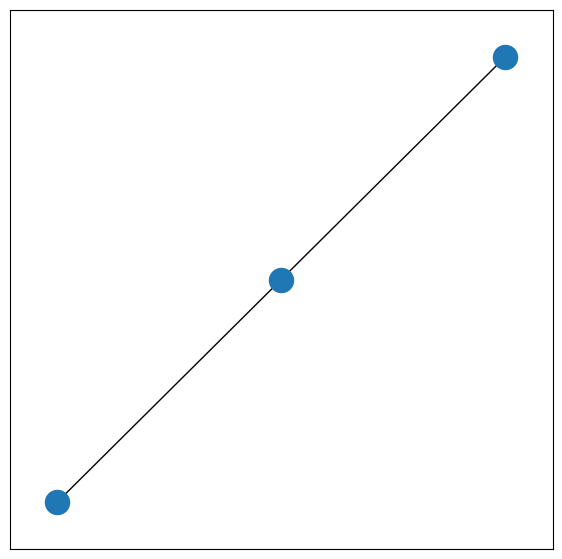

In [11]:


G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

### Exercise #1 - Building a Simple Graph ###
Let's create the  graph for the Molecule below. 

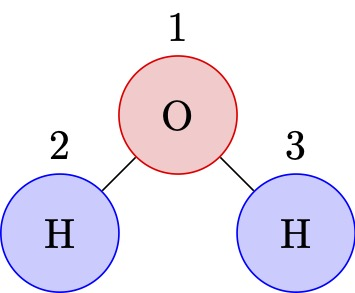


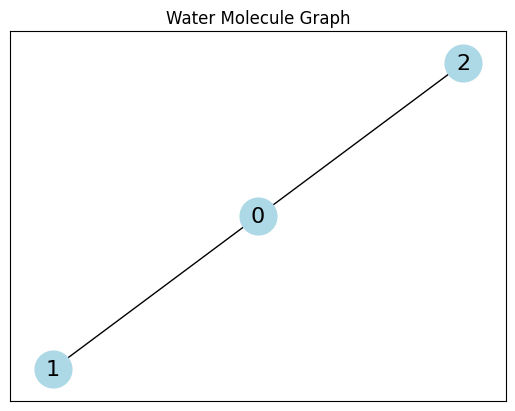

In [12]:


# 1. Task: Define the edges of the water molecule
# The water molecule consists of Oxygen (node 0) connected to two Hydrogens (nodes 1 and 2).
# Define the `edge_index` tensor to represent these bonds.
#  TODO: Replace <<<# TODO>>> with the appropriate node indices
edge_index = torch.tensor([
    [0,1],
    [1,0],    # Edge from Oxygen (node 0) to Hydrogen 1 (node 1)
    [0,2],
    [2,0]      # Edge from Oxygen (node 0) to Hydrogen 2 (node 2)
], dtype=torch.long).t().contiguous()

# 2. Task: Define the node features
# Each node should represent an atom. Oxygen can be labeled with 0, and Hydrogens with 1.
# TODO: Replace <<<# TODO>>> with node features (e.g., atomic labels)
x = torch.tensor([
    [0],  # Oxygen atom (label 0)
    [1],  # Hydrogen atom 1 (label 1)
    [1]   # Hydrogen atom 2 (label 1)
], dtype=torch.float)

# 3. Task: Create the graph data object for PyTorch Geometric
# This will store the node features and edge information.
data = Data(x=x, edge_index=edge_index)

# 4. Task: Convert the PyTorch Geometric graph to a NetworkX graph
# Use the to_networkx function to convert the graph.
G = to_networkx(data, to_undirected=True)

# 5. Task: Visualize the graph using NetworkX
# Use the spring layout for positioning the nodes and draw the graph.
pos = nx.spring_layout(G)  # Layout for positioning the nodes
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)

# Add title to the plot
plt.title("Water Molecule Graph")
plt.show()


### Question to Answer:

Why do we need to use `dtype=torch.long).t().contiguous()` when defining the `edge_index` tensor? 


<details>
<summary>Click to show Answer:</summary>

These operations together prepare the `edge_index` tensor for use in PyTorch Geometric, where it needs to store node indices in the correct format and ensure efficient memory usage.

```python
import torch

# Create an edge_index tensor without dtype, transpose, or contiguous
edge_index = torch.tensor([
    [0, 1],
    [0, 2]
])

print("Original edge_index tensor:")
print(edge_index)

# Now apply dtype=torch.long, .t(), and .contiguous()
edge_index_corrected = edge_index.to(dtype=torch.long).t().contiguous()

print("\nCorrected edge_index tensor:")
print(edge_index_corrected)
```
</details>



In [20]:


# Define the source and destination nodes (edges) for the water molecule
# Example: [0, 0] for edges originating from the oxygen atom, [1, 2] for hydrogen atoms
edge_index = torch.tensor([
    [0, 1],  # Edge from Oxygen (node 0) to Hydrogen 1 (node 1)
    [0, 2]   # Edge from Oxygen (node 0) to Hydrogen 2 (node 2)
], dtype=torch.long).t().contiguous()

# Node features (optional) - 3 nodes: Oxygen and two Hydrogens
# For simplicity, let's just use dummy features (e.g., atom type indices)
x = torch.tensor([
    [0],  # Oxygen atom, can be replaced with actual features
    [1],  # Hydrogen atom 1
    [1]   # Hydrogen atom 2
], dtype=torch.float)

# Create the graph data object for PyTorch Geometric
data = Data(x=x, edge_index=edge_index)

print(data)


Data(x=[3, 1], edge_index=[2, 2])


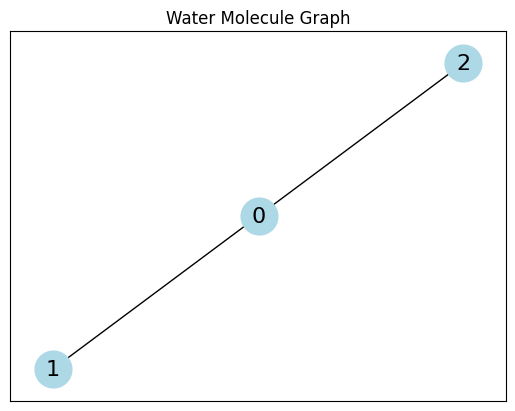

In [21]:
# Convert PyTorch Geometric graph to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Draw the graph using NetworkX
pos = nx.spring_layout(G)  # Layout for positioning the nodes
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)

# Add title to the plot (optional)
plt.title("Water Molecule Graph")
plt.show()

In [22]:
# Get adjacency matrix
adj_matrix = torch.zeros(data.num_nodes, data.num_nodes)
for i, j in data.edge_index.t():
    adj_matrix[i, j] = 1

# Print the adjacency matrix, node features, and edge features
print("Adjacency Matrix:")
print(adj_matrix)

print("\nNode Features :")
print(data.x)

print("\nEdge Features :")

Adjacency Matrix:
tensor([[0., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])

Node Features :
tensor([[0.],
        [1.],
        [1.]])

Edge Features :


Let's create the  graph for the Molecule below. 

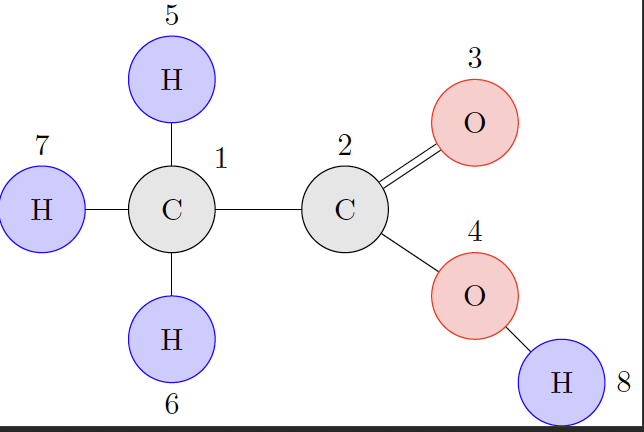 

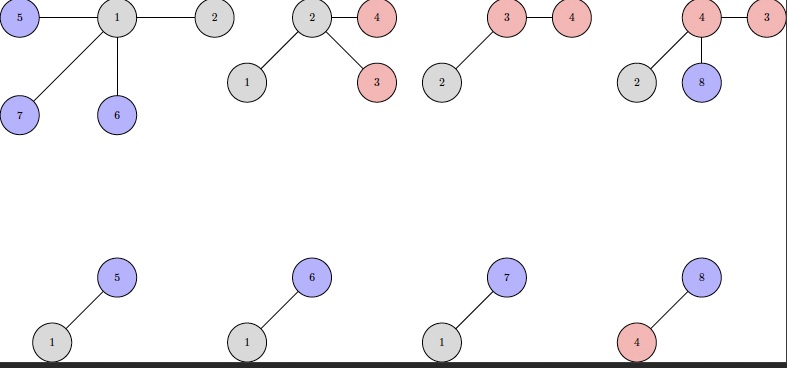

In [23]:
import torch
from torch_geometric.data import Data

# To Do: Define node features for a molecular graph.
# Here, we use dummy features (e.g., one-hot encoding of element types)
# C = [1, 0, 0], O = [0, 1, 0], H = [0, 0, 1]
# Add features for each atom (C, O, H) in the molecule.

node_features = torch.tensor([
    [1, 0, 0],  # Node 1: C (Carbon)
    [1, 0, 0],  # Node 2: C (Carbon)
    [0, 1, 0],  # Node 3: O (Oxygen)
    [0, 1, 0],  # Node 4: O (Oxygen)
    [0, 0, 1],  # Node 5: H (Hydrogen)
    [0, 0, 1],  # Node 6: H (Hydrogen)
    [0, 0, 1],  # Node 7: H (Hydrogen)
    [0, 0, 1],  # Node 8: H (Hydrogen)
], dtype=torch.float)

# To Do: Define the edges (bonds) in the graph.
# Edges are represented by pairs of connected nodes (indices of node_features).
# The following edges represent bonds between the atoms in the molecule.
# For example, the bond between Carbon (node 1) and Hydrogen (node 5) is [0, 4].
# The edge_index tensor represents all edges in the graph as pairs of nodes.

edge_index = torch.tensor([
    [0,1], [1,0],  # Bond between C (1) and C (2)
     [0,4], [4,0],   # Bond between C (1) and H (5)
    [0,5],[5,0],   # Bond between C (1) and H (6)
    [0,6], [6,0],   # Bond between C (1) and H (7)
    [1,2],[2,1],   # Bond between C (2) and O (3)
    [1,3],[3,1],   # Bond between C (2) and O (4)
    [3,7], [7,3]   # Bond between O (4) and H (8)
], dtype=torch.long).t().contiguous()  # Transpose to get shape [2, num_edges]


# This Data object will hold the graph information, including nodes, edges, and node features.
# The Data class will also be used for further processing in graph neural networks.

graph = Data(x=node_features, edge_index=edge_index)


# Print the graph details to check if the graph was correctly created.

print(graph)

# To Do: You can now use this graph for graph-based machine learning tasks, such as training a Graph Neural Network (GNN).
# The next step would be to define a GNN model and use this graph to learn from it.


Data(x=[8, 3], edge_index=[2, 14])


In [24]:
# Get adjacency matrix
adj_matrix = torch.zeros(graph.num_nodes, graph.num_nodes)
for i, j in graph.edge_index.t():
    adj_matrix[i, j] = 1

# Print the adjacency matrix, node features, and edge features
print("Adjacency Matrix:")
print(adj_matrix)

print("\nNode Features :")
print(graph.x)

print("\nEdge Features :")
print(graph.edge_attr)

Adjacency Matrix:
tensor([[0., 1., 0., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]])

Node Features :
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

Edge Features :
None


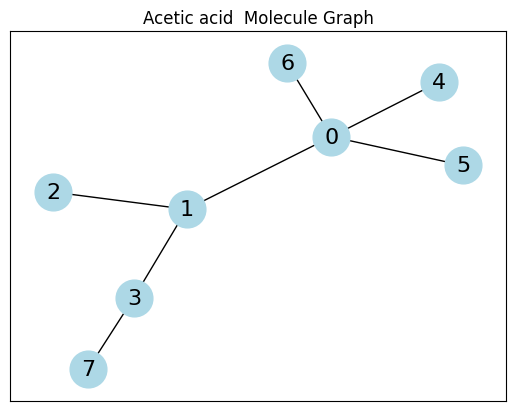

In [25]:



# Convert PyTorch Geometric graph to a NetworkX graph
G = to_networkx(graph, to_undirected=True)

# Draw the graph using NetworkX
pos = nx.spring_layout(G)  # Layout for positioning the nodes
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)

# Add title to the plot (optional)
plt.title("Acetic acid  Molecule Graph")
plt.show()


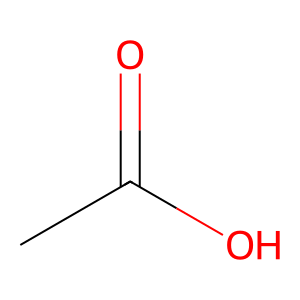

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# SMILES code for acetic acid molecule
acetic_acid_smiles = 'CC(=O)O'

# Convert SMILES to a RDKit molecule object
acetic_acid_molecule = Chem.MolFromSmiles(acetic_acid_smiles)

# Draw the molecule and display it in the notebook
acetic_acid_image = Draw.MolToImage(acetic_acid_molecule, size=(300, 300))

# Use IPython's display function to show the image
display(acetic_acid_image)

In [27]:
# Convert SMILES to graph
data = smiles2graph(acetic_acid_smiles)


print(data)

Data(x=[8, 2], edge_index=[2, 14], edge_attr=[14, 1])


In [28]:
# Get adjacency matrix
adj_matrix = torch.zeros(data.num_nodes, data.num_nodes)
for i, j in data.edge_index.t():
    adj_matrix[i, j] = 1

# Print the adjacency matrix, node features, and edge features
print("Adjacency Matrix:")
print(adj_matrix)




Adjacency Matrix:
tensor([[0., 1., 0., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]])


In [29]:
print("\nNode Features :")
print(data.x)




Node Features :
tensor([[ 2.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.]])


In [30]:
print("\nEdge Features :")
print(data.edge_attr)




Edge Features :
tensor([[1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


- Finding Node With Highest Number of Connections 

In [31]:
# Compute degree of each node
degrees = adj_matrix.sum(dim=1)
print("\nNode degrees:")
for i, degree in enumerate(degrees):
    print(f"Node {i}: {degree.item()}")


Node degrees:
Node 0: 4.0
Node 1: 3.0
Node 2: 1.0
Node 3: 2.0
Node 4: 1.0
Node 5: 1.0
Node 6: 1.0
Node 7: 1.0


## simple GNN

### Linear Layer Implementation

In a **Linear layer**, each node’s feature is transformed through a weight matrix without considering its neighbors in the graph.

The output for a single node in a **Linear layer** is given by:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

Where:
- $\mathbf{W}^{(\ell + 1)}$ is a trainable weight matrix with shape `[num_output_features, num_input_features]`.
- $\mathbf{x}_v^{(\ell)}$ represents the feature vector of node $v$ at layer $\ell$.

In this case, the transformation only depends on the feature of the node itself ($\mathbf{x}_v^{(\ell)}$) and does not include information from neighboring nodes or any graph structure. This is different from graph-based layers like the GCN, which aggregate information from neighbors in the graph.


In [32]:
import torch
import torch.nn as nn

# Define the Linear Layer (No neighbor aggregation)
class SimpleGNNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleGNNLayer, self).__init__()
        # Initialize the weight matrix W^(l+1)
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        # Initialize activation function (ReLU in this case)
        self.activation = nn.ReLU()

    def forward(self, data):
        # Node features (x) from the PyTorch Geometric data object
        x = data.x
        
        # Apply the weight matrix transformation for each node
        output = x.matmul(self.weight)  # Each node is transformed using its own feature
        
        # Apply activation function (ReLU) to introduce non-linearity
        #output = self.activation(output)
        
        return output



# Define the GNN layer (2 input features, 2 output features)
gnn_layer = SimpleGNNLayer(in_features=2, out_features=3)

# Forward pass through the GNN layer
output = gnn_layer(data)

# Print the output features 
print("Output Features:")
print(output)

Output Features:
tensor([[-0.7579,  2.5997, -2.1787],
        [-0.3789,  1.2998, -1.0894],
        [-0.3789,  1.2998, -1.0894],
        [-0.3789,  1.2998, -1.0894],
        [ 0.3789, -1.2998,  1.0894],
        [ 0.3789, -1.2998,  1.0894],
        [ 0.3789, -1.2998,  1.0894],
        [ 0.3789, -1.2998,  1.0894]], grad_fn=<MmBackward0>)


###  Graph Convolutional Networks (GCNs)

Graph Convolutional Networks (GCNs) were introduced by([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) at the University of Amsterdam. 

GCNs are similar to convolutions in images, where the “filter” parameters are shared across all locations in the graph. 

However, GCNs also rely on message passing, meaning that nodes (vertices) exchange information with their neighbors by sending "messages" to each other.

#### How GCNs Work

1. **Node Feature Creation**: Each node creates a feature vector that represents the message it wants to send to its neighbors.
2. **Message Passing**: The messages are sent to the neighbors, so each node receives one message per adjacent node.

The messages received by a node need to be aggregated, and since the number of neighbors varies across nodes, a suitable aggregation operation (like summing or averaging) is applied. 

In mathematical terms, the GCN layer can be formulated as follows:

$$
\mathbf{x}_v^{(\ell + 1)} = \sigma \left( \sum_{w \in \mathcal{N}(v) \cup \{v\}} \frac{1}{c_{w,v}} \mathbf{W}^{(\ell + 1)} \mathbf{x}_w^{(\ell)} \right)
$$

Where:
- $\mathbf{W}$ is the weight matrix used to transform the input features into messages.
- $\mathcal{N}(v)$ represents the set of neighbors of node $v$.
- $c_{w,v}$ is a normalization factor (e.g., the degree of the node $v$).
- $\sigma$ is the activation function (typically a ReLU activation function is used in GNNs).






## Graph Convolutions

[`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module is designed for graph convolution operations.

 

In [40]:
import torch
import torch.nn as nn

class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        """
        Initializes the Graph Convolutional Layer.
        
        Args:
            c_in (int): Number of input features per node.
            c_out (int): Number of output features per node.
        """
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Forward pass for the GCN layer.
        
        Args:
            node_feats (Tensor): Node features of shape [batch_size, num_nodes, c_in].
            adj_matrix (Tensor): Adjacency matrix of the graph(s) of shape [batch_size, num_nodes, num_nodes].
            
        Returns:
            Tensor: Updated node features of shape [batch_size, num_nodes, c_out].
        """
        # Step 1: Normalize adjacency matrix (self-loops already included)
        # Calculate the degree matrix (number of neighbors per node)
        degree_matrix = adj_matrix.sum(dim=-1, keepdims=True)  # Sum along the last dimension (number of neighbors per node)
        # Step 2: Apply the linear transformation to the node features
        node_feats = self.projection(node_feats)  # Apply linear transformation to features (shape: [batch_size, num_nodes, c_out])
        
        # Step 3: Aggregate messages by performing matrix multiplication between the adjacency matrix and node features
        # Perform batch matrix multiplication (for all graphs in the batch to aggregate features from neighbors)
        aggregated_feats = torch.bmm(adj_matrix, node_feats)  # Shape: [batch_size, num_nodes, c_out]
        
        # Step 4: Normalize by the degree matrix (normalize by number of neighbors)
        aggregated_feats = aggregated_feats / degree_matrix  # Shape: [batch_size, num_nodes, c_out]
        
        # Return the updated node features
        return aggregated_feats


In [41]:
from torch  import Tensor

# Example SMILES string for carbon dioxide CO2
smiles = "O=C=O"

# Convert SMILES string to graph
graph= smiles2graph(smiles)

# Get adjacency matrix
adj_matrix = torch.zeros(graph.num_nodes, graph.num_nodes)
for i, j in graph.edge_index.t():
    adj_matrix[i, j] = 1

adj_matrix = adj_matrix.unsqueeze(0)

# Print the adjacency matrix, node features, and edge features
print("Adjacency Matrix:")
print(adj_matrix)

print("\nNode Features :")
node_feats= graph.x.unsqueeze(0)
print(node_feats)

print("\nEdge Features :")
print(graph.edge_attr)

Adjacency Matrix:
tensor([[[0., 1., 0.],
         [1., 0., 1.],
         [0., 1., 0.]]])

Node Features :
tensor([[[1., 0.],
         [0., 0.],
         [1., 0.]]])

Edge Features :
tensor([[2.],
        [2.],
        [2.],
        [2.]])


In [43]:

# Create the GCN layer
layer = GCNLayer(c_in=2, c_out=2)  # Transform 3 input features into 2 output features

# Set the weight matrix to be the identity matrix
layer.projection.weight.data = Tensor([[1.0, 0.0], [0.0, 1.0]])

# Set the bias to zero
layer.projection.bias.data = Tensor([0.0, 0.0])


# Perform the forward pass through the GCN layer (without updating gradients)
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[0., 1., 0.],
         [1., 0., 1.],
         [0., 1., 0.]]])
Input features tensor([[[1., 0.],
         [0., 0.],
         [1., 0.]]])
Output features tensor([[[0., 0.],
         [1., 0.],
         [0., 0.]]])


### Message Passing in GNNs

Formally, the message passing algorithm can be described as:
$$
message :  m_{vw}^{t+1} = M(h_{v}^{t},h_{w}^{t}, e_{v,w} )
$$

$$
aggregation : m_{v}^{t+1} = \sum_{w \in \mathcal{N}(v)} m_{vw}^{t+1}
$$

$$
Update : h_{v}^{t+1} = U(h_{v}^{t},  m_{v}^{t+1})
$$

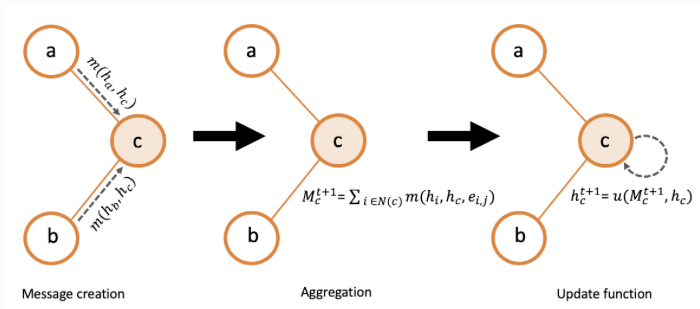

### Message-Passing Framework

In the **message-passing** framework, we update the feature vector $\mathbf{x}_v$ of each node $v$ iteratively by aggregating information from neighboring nodes $\mathcal{N}(v)$ in the graph. The process is split into three main steps: **message**, **aggregation**, and **update**.

#### 1. **Message Step**:

In this step, each node sends a "message" to its neighbors. The message from node $v$ to node $w$ is defined as:

$$
m_{vw}^{\ell+1} = M(\mathbf{x}_v^{\ell}, \mathbf{x}_w^{\ell}, e_{v,w})
$$

Where:
- $m_{vw}^{\ell+1}$ is the message from node $v$ to node $w$ at step $\ell+1$.
- $\mathbf{x}_v^{\ell}$ and $\mathbf{x}_w^{\ell}$ are the feature vectors of node $v$ and node $w$ at step $\ell$.
- $e_{v,w}$ is the edge feature between node $v$ and node $w$ (if applicable).
- $M(\cdot)$ is a function that computes the message based on the feature vectors of nodes $v$ and $w$ as well as the edge feature $e_{v,w}$.

The message step represents how each node communicates information to its neighbors, using both its own features and the features of its neighbors (and possibly edge features).

#### 2. **Aggregation Step**:

After the message passing, each node aggregates the messages from all of its neighbors. This is expressed as:

$$
m_{v}^{\ell+1} = \sum_{w \in \mathcal{N}(v)} m_{vw}^{\ell+1}
$$

Where:
- $m_{v}^{\ell+1}$ is the aggregated message for node $v$ at step $\ell+1$.
- $\mathcal{N}(v)$ represents the set of neighboring nodes of $v$.
- The sum $\sum_{w \in \mathcal{N}(v)} m_{vw}^{\ell+1}$ aggregates the individual messages sent by the neighbors $w$ of node $v$.

This step allows each node to gather information from its neighbors by combining all the incoming messages. The aggregation function could also be more sophisticated (e.g., weighted sum, average), but here it's a simple sum.

#### 3. **Update Step**:

Finally, each node updates its feature vector based on the aggregated message. The update rule is:

$$
\mathbf{x}_v^{\ell+1} = U(\mathbf{x}_v^{\ell}, m_{v}^{\ell+1})
$$

Where:
- $\mathbf{x}_v^{\ell+1}$ is the updated feature vector of node $v$ at step $\ell+1$.
- $\mathbf{x}_v^{\ell}$ is the feature vector of node $v$ at the previous step $\ell$.
- $m_{v}^{\ell+1}$ is the aggregated message for node $v$ at step $\ell+1$.
- $U(\cdot)$ is a function that updates the feature vector of node $v$ based on its previous feature vector $\mathbf{x}_v^{\ell}$ and the aggregated message $m_{v}^{\ell+1}$.

The update function $U$ typically involves combining the current node feature $\mathbf{x}_v^{\ell}$ with the aggregated message $m_{v}^{\ell+1}$ and applying a non-linear transformation (e.g., a neural network layer, ReLU activation, etc.).

---

### Putting It All Together:

1. **Message**: Each node $v$ sends a message to each of its neighbors $w$ based on its current feature $\mathbf{x}_v^{\ell}$, the neighbor’s feature $\mathbf{x}_w^{\ell}$, and any edge feature $e_{v,w}$.
2. **Aggregation**: Each node aggregates the messages from all its neighbors by summing them (or using another aggregation method).
3. **Update**: Each node updates its own feature vector based on its previous feature $\mathbf{x}_v^{\ell}$ and the aggregated messages $m_{v}^{\ell+1}$.

This iterative process allows nodes to update their features based on the information from their neighbors, helping them to capture graph-based dependencies over multiple layers of message passing.


### Graph Convolutional Network (GCN) Implementation

To simplify the implementation, the adjacency matrix is modified by adding the identity matrix to include self-loops (so that each node also sends a message to itself). 

Additionally, the message aggregation can be performed using summation or averaging, which is typically achieved by dividing the summed messages by the number of neighbors after the summation.

The equation for the update of node features in a Graph Convolutional Network (GCN) can be written as:

$$
X^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}X^{(l)}W^{(l)}\right)
$$

Where:
- $X^{(l)}$ is the feature matrix of nodes at layer $l$.
- $\hat{A} = A+I$ is the adjacency matrix of the graph (including self-loops: so that each node sends its own message also to itself).
- $\hat{D}$ is the degree matrix (diagonal matrix), where each entry $\hat{D}_{ii}$ represents the degree of node $i$.
- $W^{(l)}$ is the learnable weight matrix for layer $l$.
- $\sigma$ is a non-linear activation function (typically ReLU).

#### Explanation:
- The term $\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}$ represents the normalized adjacency matrix, where $\hat{D}^{-1/2}$ is the inverse square root of the degree matrix.
- This normalization is crucial for controlling the influence of each node's neighbors, especially for large or unbalanced graphs.
- The feature matrix $X^{(l)}$ is multiplied by the weight matrix $W^{(l)}$ to transform the features, and the result is passed through the non-linearity $\sigma$.


In [45]:
import torch
import torch.nn as nn

class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        """
        Initializes the Graph Convolutional Layer.
        
        Args:
            c_in (int): Number of input features per node.
            c_out (int): Number of output features per node.
        """
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Forward pass for the GCN layer.
        
        Args:
            node_feats (Tensor): Node features of shape [batch_size, num_nodes, c_in].
            adj_matrix (Tensor): Adjacency matrix of the graph(s) of shape [batch_size, num_nodes, num_nodes].
            
        Returns:
            Tensor: Updated node features of shape [batch_size, num_nodes, c_out].
        """
        # Step 1: Normalize adjacency matrix (self-loops already included)
        # Calculate the degree matrix (number of neighbors per node)
        degree_matrix = adj_matrix.sum(dim=-1, keepdims=True)  # Sum along the last dimension (number of neighbors per node)
        # Step 2: Apply the linear transformation to the node features
        node_feats = self.projection(node_feats)  # Apply linear transformation to features (shape: [batch_size, num_nodes, c_out])
        
        # Step 3: Aggregate messages by performing matrix multiplication between the adjacency matrix and node features
        # Perform batch matrix multiplication (for all graphs in the batch to aggregate features from neighbors)
        aggregated_feats = torch.bmm(adj_matrix, node_feats)  # Shape: [batch_size, num_nodes, c_out]
        
        # Step 4: Normalize by the degree matrix (normalize by number of neighbors)
        aggregated_feats = aggregated_feats / degree_matrix  # Shape: [batch_size, num_nodes, c_out]
        
        # Return the updated node features
        return aggregated_feats


### Key Points:
- **Shape Consistency**: `torch.bmm()` requires both tensors to have 3 dimensions. If you're working with a single graph, you need to add a batch dimension to make it `[1, num_nodes, num_nodes]` for the adjacency matrix and `[1, num_nodes, num_features]` for the node features.


In [46]:
from torch  import Tensor

# Example SMILES string for carbon dioxide CO2
smiles = "O=C=O"

# Convert SMILES string to graph
graph= smiles2graph(smiles)

# Get adjacency matrix
adj_matrix = torch.zeros(graph.num_nodes, graph.num_nodes)
for i, j in graph.edge_index.t():
    adj_matrix[i, j] = 1

adj_matrix = adj_matrix.unsqueeze(0)

# Print the adjacency matrix, node features, and edge features
print("Adjacency Matrix:")
print(adj_matrix)

print("\nNode Features :")
node_feats= graph.x.unsqueeze(0)
print(node_feats)

print("\nEdge Features :")
print(graph.edge_attr)



Adjacency Matrix:
tensor([[[0., 1., 0.],
         [1., 0., 1.],
         [0., 1., 0.]]])

Node Features :
tensor([[[1., 0.],
         [0., 0.],
         [1., 0.]]])

Edge Features :
tensor([[2.],
        [2.],
        [2.],
        [2.]])


In [47]:
# Create the GCN layer
layer = GCNLayer(c_in=2, c_out=2)  # Transform 3 input features into 2 output features

# Set the weight matrix to be the identity matrix
layer.projection.weight.data = Tensor([[1.0, 0.0], [0.0, 1.0]])

# Set the bias to zero
layer.projection.bias.data = Tensor([0.0, 0.0])


# Perform the forward pass through the GCN layer (without updating gradients)
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

# Print output features
print("Output Features:")
print(out_feats)

Output Features:
tensor([[[0., 0.],
         [1., 0.],
         [0., 0.]]])


## Pooling

### **1. Sum Pooling**

Sum pooling aggregates node features by summing them, which captures the total contribution of all nodes.

#### **Equation**:
$$
\mathbf{h}_{\text{graph}} = \sum_{i \in \mathcal{V}} \mathbf{h}_i
$$

#### **Key Property**:
- Aggregates all node features by summing their contributions.


In [48]:
import torch
from torch_geometric.nn import global_add_pool

# Example features and batch assignments
node_feats = torch.tensor([[1.0, 2.0],  # Node 0
                           [3.0, 4.0],  # Node 1
                           [5.0, 6.0],  # Node 2
                           [7.0, 8.0]]) # Node 3
batch = torch.tensor([0, 0, 1, 1])  # Two graphs: 0 & 1

# Sum pooling
sum_pool = global_add_pool(node_feats, batch)
print("Sum Pooling:", sum_pool)


Sum Pooling: tensor([[ 4.,  6.],
        [12., 14.]])


### **2. Mean Pooling**

Mean pooling aggregates node features by taking their average, capturing the overall trend or average representation of the nodes.

#### **Equation**:
$$
\mathbf{h}_{\text{graph}} = \frac{1}{|\mathcal{V}|} \sum_{i \in \mathcal{V}} \mathbf{h}_i
$$

#### **Key Property**:
- Computes the average contribution of all node features.


In [49]:
from torch_geometric.nn import global_mean_pool

# Mean pooling
mean_pool = global_mean_pool(node_feats, batch)
print("Mean Pooling:", mean_pool)


Mean Pooling: tensor([[2., 3.],
        [6., 7.]])


In [50]:
from torch_geometric.nn import global_mean_pool

# Mean pooling
mean_pool = global_mean_pool(node_feats, batch)
print("Mean Pooling:", mean_pool)


Mean Pooling: tensor([[2., 3.],
        [6., 7.]])


### **3. Max Pooling**

Max pooling selects the maximum value for each feature across all nodes, emphasizing the most significant feature contributions.

#### **Equation**:
$$
\mathbf{h}_{\text{graph}} = \max_{i \in \mathcal{V}} \mathbf{h}_i
$$

#### **Key Property**:
- Captures the most dominant feature from all node contributions.


In [51]:
from torch_geometric.nn import global_max_pool

# Max pooling
max_pool = global_max_pool(node_feats, batch)
print("Max Pooling:", max_pool)


Max Pooling: tensor([[3., 4.],
        [7., 8.]])


### **4. Attention Pooling**

Attention pooling computes a weighted sum of node features, where weights are learned based on the node importance.

#### **Equation**:
$$
\mathbf{h}_{\text{graph}} = \sum_{i \in \mathcal{V}} \alpha_i \mathbf{h}_i
$$

#### **Key Property**:
- Allows the model to focus on the most relevant nodes by learning weights (\(\alpha_i\)) for each node.


In [52]:
import torch
from torch.nn.functional import softmax

# Example attention weights (randomly initialized for demonstration)
attention_weights = softmax(torch.tensor([1.0, 2.0, 3.0, 4.0]), dim=0)
node_feats = torch.tensor([[1.0, 2.0],  # Node 0
                           [3.0, 4.0],  # Node 1
                           [5.0, 6.0],  # Node 2
                           [7.0, 8.0]]) # Node 3

# Weighted sum (attention-based pooling)
weighted_feats = attention_weights.view(-1, 1) * node_feats
attention_pool = weighted_feats.sum(dim=0)
print("Attention-based Pooling:", attention_pool)


Attention-based Pooling: tensor([5.9853, 6.9853])
